Visualisieren:
../../libMultiRobotPlanning-master/example/visualize.py test.yaml output.yaml


Basic Info:
[North, East, South, West]
DO_NOTHING= 0 MOVE_FORWARD= 2 MOVE_LEFT= 1 MOVE_RIGHT= 3 STOP_MOVING= 4

In [3]:
import PIL
import yaml
import random
import sys
import time
from typing import Optional, List, Dict
import subprocess

import numpy as np

from flatland.core.env import Environment
from flatland.core.env_observation_builder import ObservationBuilder
from flatland.core.grid.grid_utils import coordinate_to_position
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.ordered_set import OrderedSet
from flatland.utils.rendertools import RenderTool
from flatland.core.grid.grid4_utils import get_new_position

from flatland.envs.rail_generators import rail_from_manual_specifications_generator
from flatland.envs.rail_generators import rail_from_file

from flatland.utils.misc import str2bool


random.seed(100)
np.random.seed(100)

direction_to_str = {0: "North", 1: "East", 2: "South", 3: "West"}

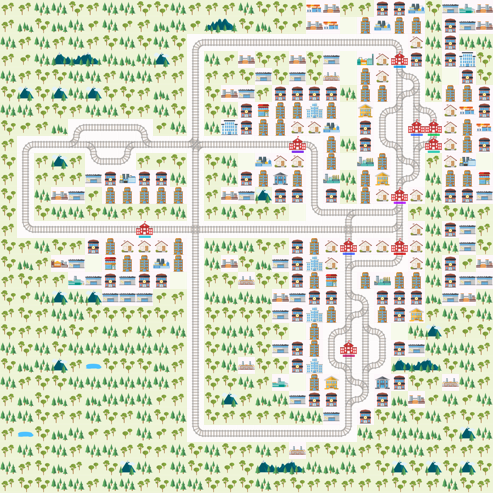

{'action_required': {0: True, 1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 7: True, 8: True, 9: True}, 'malfunction': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 'speed': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}, 'status': {0: <RailAgentStatus.READY_TO_DEPART: 0>, 1: <RailAgentStatus.READY_TO_DEPART: 0>, 2: <RailAgentStatus.READY_TO_DEPART: 0>, 3: <RailAgentStatus.READY_TO_DEPART: 0>, 4: <RailAgentStatus.READY_TO_DEPART: 0>, 5: <RailAgentStatus.READY_TO_DEPART: 0>, 6: <RailAgentStatus.READY_TO_DEPART: 0>, 7: <RailAgentStatus.READY_TO_DEPART: 0>, 8: <RailAgentStatus.READY_TO_DEPART: 0>, 9: <RailAgentStatus.READY_TO_DEPART: 0>}}


In [22]:
env = RailEnv(
        width=0,
        height=0,
        rail_generator=rail_from_file("../scratch/test-envs/Test_10/Level_1.pkl"),
        number_of_agents=10
    )

_, info = env.reset()


render_env(env)

print(info)

In [2]:
class FirstStepsAgent:

    def __init__(self, handle, schedule):        
        self.result_schedule = schedule
        self.handle = handle
        
        self.init = 0
        

    def act(self, sch):
        """
        :param state: input is the observation of the agent
        :return: returns an action
        """
        
        # "Ignore" the first step and just start with a forward move
        if self.init == 0:
            self.init = 1
            
            return 2
        
        elif self.init == 1:
            
            # Get the position and the direction of the agent based on the observation
            pos = obs.position
            direction = obs.direction

            # Get the the calculated position where the agent has to move
            target = obs.target

            # Search in the System for the actions to get to the goal
            self.result_schedule = a_star(self.handle, pos, direction, target)
        
            self.init = 2
            return self.result_schedule.pop(0)

        
        elif self.init == 2 and not self.result_schedule.is_empty():
            
            return self.result_schedule.pop(0)
        
        elif self.init == 2 and self.result_schedule.is_empty():

            return 0            


In [3]:
class Observation():
    def __init__(self, position, direction, target):
        self.position = position 
        self.direction = direction
        self.target = target

class ObservePredictions(ObservationBuilder):

    def __init__(self):
        super().__init__()

    def reset(self):
        pass

    def get_many(self, handles: Optional[List[int]] = None) -> Dict[int, np.ndarray]:
        observations = {}
        

        # Collect all the different observation for all the agents
        for h in handles:
            observations[h] = self.get(h)

        return observations

    def get(self, handle: int = 0) -> np.ndarray:
        
        agent = self.env.agents[handle]
        
        # self.env.dev_pred_dict[handle] = get_computed_path(handle)
        
        return Observation(agent.position, agent.direction, agent.target)

    def set_env(self, env: Environment):
        super().set_env(env)

In [13]:
render = False

try:
    
    
    # Pass the Predictor to the observation builder
    custom_obs_builder = ObservePredictions()

    # Initiate Environment
    env = RailEnv(width=10, height=10,
                  rail_generator=complex_rail_generator(nr_start_goal=5, nr_extra=1, min_dist=8, max_dist=99999,
                                                        seed=1), schedule_generator=complex_schedule_generator(),
                  number_of_agents=3, obs_builder_object=custom_obs_builder)

    obs, info = env.reset()
    env_renderer = RenderTool(env, screen_width=2000, screen_height=2000)

    # We render the initial step
    if render : env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
        
    # Initialize the agent    
    agent = [FirstStepsAgent(handle) for handle in range(env.get_num_agents())]
    
    
    # Empty action dictionary which has the predicted actions in it for each step
    action_dict = dict()
    
    # For Loop with all the steps predicted by the agent
    for step in range(25):
        
        for a in range(env.get_num_agents()):
        
            action_dict[a] = agent[a].act(obs[a])
        
        # Do the actual step in the Enviroment based on the action_dict computed previously 
        obs, all_rewards, done, info = env.step(action_dict)
        
        for handle, action in action_dict.items():
            print(f"<{handle}> Action: |{action}|, Position: {env.agents[handle].position}, Target: {env.agents[handle].target}, Direction: {direction_to_str[env.agents[handle].direction]}")

        print("Rewards: ", all_rewards, "  [done=", done, "]", end="\n" + 50 * "-" + "\n\n")
        
        if render: env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
            
        if render: time.sleep(1)

        if done["__all__"]:
            print("All done!")
            break
            
finally:
    if render : env_renderer.close_window()


<0> Action: |2|, Position: (9, 8), Target: (8, 0), Direction: East
<1> Action: |2|, Position: (0, 3), Target: (8, 2), Direction: North
<2> Action: |2|, Position: (2, 0), Target: (0, 9), Direction: West
Rewards:  {0: -1.0, 1: -1.0, 2: -1.0}   [done= {0: False, 1: False, 2: False, '__all__': False} ]
--------------------------------------------------

<0> Action: |2|, Position: (9, 7), Target: (8, 0), Direction: West
<1> Action: |2|, Position: (1, 3), Target: (8, 2), Direction: South
<2> Action: |2|, Position: (2, 1), Target: (0, 9), Direction: East
Rewards:  {0: -1.0, 1: -1.0, 2: -1.0}   [done= {0: False, 1: False, 2: False, '__all__': False} ]
--------------------------------------------------

<0> Action: |2|, Position: (9, 6), Target: (8, 0), Direction: West
<1> Action: |2|, Position: (2, 3), Target: (8, 2), Direction: South
<2> Action: |2|, Position: (2, 2), Target: (0, 9), Direction: East
Rewards:  {0: -1.0, 1: -1.0, 2: -1.0}   [done= {0: False, 1: False, 2: False, '__all__': False

In [23]:

Debug = False

# Position, action, cost, direction
def calc_next_cell(position, direction, handle):
    
    possible_transitions = env.rail.get_transitions(*position, direction)

    if all(d == 0 for d in possible_transitions):
        print("This Direction is not permissable!")
        return -1
    
    next_cells = []
    # Loop trough all the possible dirrections the agent can reach from current direction
    for d in [(direction + i) % 4 for i in range(-1, 2)]:
        
        if possible_transitions[d]:
            
            # Die neue Position, wenn man die jeweilige direction 
            new_position = get_new_position(position, d)
            
            
            # Die Distanz von einer Position zum Ziel des jeweiligen Agenten
            dist = env.distance_map.get()[handle, new_position[0], new_position[1], d]
            
            # Check the given directions and map it to the corresponding action
            if d == direction:
                if Debug: print(f"Action forward, to: {new_position}, dist: {dist}")
                next_cells.append((new_position, 2, dist, d))
                
            
            elif (d + 1) % 4 == direction:
                if Debug: print(f"Action left, to: {new_position}, dist: {dist}")
                next_cells.append((new_position, 1, dist, d))
                
            elif (d - 1) % 4 == direction:
                if Debug: print(f"Action right, to: {new_position}, dist: {dist}") 
                next_cells.append((new_position, 3, dist, d))
    
    else:
    
        # Check if the transition is an dead End
        if possible_transitions[(direction + 2) % 4] == 1:
            direction = (direction + 2) % 4

            # Die neue Position, wenn man die jeweilige direction 
            new_position = get_new_position(position, direction)


            # Die Distanz von einer Position zum Ziel des jeweiligen Agenten
            dist = env.distance_map.get()[handle, new_position[0], new_position[1], direction]

            if Debug: print(f"Dead End, to: {new_position}, dist: {dist}")
            next_cells.append((new_position, 2, dist, direction))
    
    return next_cells
            

for i in range(4):
    print(direction_to_str[i], i)
    print(calc_next_cell((2, 0), i, 2))
    print("-" * 50 + "\n")

North 0
This Direction is not permissable!
-1
--------------------------------------------------

East 1
This Direction is not permissable!
-1
--------------------------------------------------

South 2
This Direction is not permissable!
-1
--------------------------------------------------

West 3
[((2, 1), 2, 10.0, 1)]
--------------------------------------------------



In [11]:
import heapq


class A_Star_result():
    succes = 1
    fail = 2
    
    def __init__(self, status=succes, actions=[], positions=[], iterations=-1):
        self.status = status
        self.actions = actions
        self.positions = positions
        self.iterations = iterations

    def __repr__(self):
        if self.status == A_Star_result.succes:
            return f"Succes! actions: {self.actions}, positions: {self.positions}"
        else:
            return f"Failed in {self.iterations} iterations..."
        
    def is_empty(self):
        return len(self.actions) == 0
    
    def get_n_action(self, n):
        if n < 0 or n >= len(self.actions):
            raise "Error: Trying to get acces to an action with an undifinded timestep!"
            
        return self.actions[n]
    
    def pop(self, n):
        if n < 0 or n >= len(self.actions):
            raise "Error: Trying to get acces to an action with an undifinded timestep!"
        
        self.positions.pop(n)
        return self.actions.pop(n)


class Node:
    def __init__(self, position, parent, action, cost, direction):
        self.position = position
        self.parent = parent
        self.action = action
        self.cost = cost
        self.direction = direction
        
        self.state = (position, direction)
    
    def __lt__(self, other):
        return self.cost < other.cost
    
    def __repr__(self):
        return f"|p: {self.position}, a: {self.action}, c: {self.cost}|"
        
def make_root_node(position, direction):
    return Node(position, None, None, 0, direction)

def make_node(position, parent, action, cost, direction):
    return Node(position, parent, action, cost, direction)

def extract_solution(node):
    sol = []
    sol_pos = []
    while node.parent is not None:
        sol.append(node.action)
        sol_pos.append(node.position)
        node = node.parent
    
    return (sol[::-1], sol_pos[::-1])



def a_star(handle, position, direction, goal_position, iterations=100):
    open_list = []
    heapq.heappush(open_list, make_root_node(position, direction))
    
    closed_list = []
    distance = {}
    
    i = 0
    while len(open_list) > 0 and i <= iterations:
        
        node = heapq.heappop(open_list)
        
        if node.state not in closed_list or node.cost < distance[node.state]:
            
            closed_list.append(node.state)
            distance[node.state] = node.cost
            
            if node.position == goal_position:
                res = extract_solution(node)
                return A_Star_result(A_Star_result.succes, res[0], res[1])
            
            succ = calc_next_cell(node.position, node.direction, handle)
            
            for n in succ:
                heapq.heappush(open_list, make_node(n[0], node, n[1], n[2], n[3]))
        
        
        
        i += 1  # Make sure the Iterations are not that big
                
    return A_Star_result(A_Star_result.fail, iterations=i)

# Position, action, direction, goal position
# a_star(2, (7, 5), 2, (8, 3))
# a_star(2, (2, 0), 3, (2, 4))

In [29]:
import itertools 

# Pass the Predictor to the observation builder
custom_obs_builder = ObservePredictions()

# Initiate Environment

env = RailEnv(width=10, height=10,
                  rail_generator=complex_rail_generator(nr_start_goal=5, nr_extra=1, min_dist=8, max_dist=99999,
                                                        seed=1), schedule_generator=complex_schedule_generator(),
                  number_of_agents=3, obs_builder_object=custom_obs_builder)


"""
env = RailEnv(
        width=10,
        height=10,
        rail_generator=rail_from_file("../scratch/test-envs/Test_1/Level_1.pkl"),
        number_of_agents=3
    )
"""




obs, info = env.reset()
env.step({i : 2 for i in range(env.get_num_agents())})



class StateNodes():
    
    def __init__(self, node_lst):
        
        self.node_lst = node_lst
        self.cost = 0
        self.state = []
        
        for n in node_lst:
            self.cost += n[0].cost
            self.state.append((n[0].position, n[0].direction))
            
        self.state = tuple(self.state)
        self.parent = None

    def __repr__(self):
        return f"{self.node_lst}"
    
    def __eq__(self, other):
        res = True
        for handle in range(len(self.node_lst)):

            if self.get_node(handle).position != other.get_node(handle).position:
                res = False
                
        return res
    
    def __lt__(self, other):
        return self.cost < other.cost
    
    def get_node(self, handle):
        return self.node_lst[handle][0]

# Position, action, cost, direction
def get_next_states(node):
    
    # This should be an list of StateNodes.
    res = []
    
    # This loop gives a binary counter, so every state of the correspondig agent get expanded
    for lst in itertools.product([0,1], repeat=len(node.node_lst)):
        
        next_states = []
        
        for handle, apply in enumerate(lst):
            
            if apply == 1:
                
                curr_agent = node.get_node(handle)
                
                next_cells = calc_next_cell(curr_agent.position, curr_agent.direction, handle)
                
                next_nodes = [make_node(pos, curr_agent, act, cost, dire) for pos, act, cost, dire in next_cells]
                
                next_states.append(next_nodes)
            
            # Do nothing and do not expand this state
            elif apply == 0:
                
                ol = node.node_lst[handle]
                
                next_states.append(ol)
            
        prod = list(itertools.product(*next_states))
        for s in prod:
            
            state = StateNodes([[x] for x in s])
            
            if state.cost != np.inf:
            
                res.append(state)
            
    return res[1:]

        


states = []
for handle in range(env.get_num_agents()):
    agent = env.agents[handle]
    
    position = agent.position
    direction = agent.direction
    
    states.append([make_root_node(position, direction)])
    
    
get_next_states(StateNodes(states))


[[[|p: (9, 8), a: None, c: 0|], [|p: (0, 3), a: None, c: 0|], [|p: (2, 1), a: 2, c: 10.0|]],
 [[|p: (9, 8), a: None, c: 0|], [|p: (1, 3), a: 2, c: 8.0|], [|p: (2, 0), a: None, c: 0|]],
 [[|p: (9, 8), a: None, c: 0|], [|p: (1, 3), a: 2, c: 8.0|], [|p: (2, 1), a: 2, c: 10.0|]],
 [[|p: (9, 7), a: 2, c: 8.0|], [|p: (0, 3), a: None, c: 0|], [|p: (2, 0), a: None, c: 0|]],
 [[|p: (9, 7), a: 2, c: 8.0|], [|p: (0, 3), a: None, c: 0|], [|p: (2, 1), a: 2, c: 10.0|]],
 [[|p: (9, 7), a: 2, c: 8.0|], [|p: (1, 3), a: 2, c: 8.0|], [|p: (2, 0), a: None, c: 0|]],
 [[|p: (9, 7), a: 2, c: 8.0|], [|p: (1, 3), a: 2, c: 8.0|], [|p: (2, 1), a: 2, c: 10.0|]]]

In [30]:
import heapq



# nodes is an StatesNodes Object
def make_state_node(state, parent):

    nodes = state.node_lst
    
    res = StateNodes(nodes)
    res.cost += parent.cost
    res.parent = parent
    
    return res

def extract_state_solution(state):
    sol = []
    
    while state.parent is not None:
        sol.append(state)
        state = state.parent
    
    return sol[::-1]


def a_star_big(init_state, goal_state):
    open_list = []
    heapq.heappush(open_list, init_state)
    
    closed_list = []
    distance = {}
    
    while len(open_list) > 0:
        
        node = heapq.heappop(open_list)
        
        if node.state not in closed_list or node.cost < distance[node.state]:
            
            closed_list.append(node.state)
            distance[node.state] = node.cost
            
            # StateNodes == StateNodes --> position of all should be the same
            if node == goal_state:
                res = extract_state_solution(node)
                return res
            
            succ = get_next_states(node)
            
            for n in succ:
                heapq.heappush(open_list, make_state_node(n, node))



pos = []
for handle in range(env.get_num_agents()):
    agent = env.agents[handle]
    
    position = agent.position
    direction = agent.direction
    
    pos.append([make_root_node(position, direction)])
    

goal_pos = []
for handle in range(env.get_num_agents()):
    agent = env.agents[handle]
    
    goal_pos.append([make_root_node(agent.target, -1)])


result_star = a_star_big(StateNodes(pos), StateNodes(goal_pos))

for i in result_star:
    print(i)

[[|p: (9, 8), a: None, c: 0|], [|p: (0, 3), a: None, c: 0|], [|p: (2, 1), a: 2, c: 10.0|]]
[[|p: (9, 8), a: None, c: 0|], [|p: (0, 3), a: None, c: 0|], [|p: (2, 2), a: 2, c: 9.0|]]
[[|p: (9, 8), a: None, c: 0|], [|p: (0, 3), a: None, c: 0|], [|p: (2, 3), a: 2, c: 8.0|]]
[[|p: (9, 7), a: 2, c: 8.0|], [|p: (1, 3), a: 2, c: 8.0|], [|p: (2, 4), a: 2, c: 7.0|]]
[[|p: (9, 6), a: 2, c: 7.0|], [|p: (2, 3), a: 2, c: 7.0|], [|p: (2, 5), a: 2, c: 6.0|]]
[[|p: (9, 5), a: 2, c: 6.0|], [|p: (3, 3), a: 2, c: 6.0|], [|p: (2, 6), a: 2, c: 5.0|]]
[[|p: (9, 4), a: 2, c: 5.0|], [|p: (4, 3), a: 2, c: 5.0|], [|p: (2, 7), a: 2, c: 4.0|]]
[[|p: (9, 3), a: 2, c: 4.0|], [|p: (5, 3), a: 2, c: 4.0|], [|p: (2, 8), a: 2, c: 3.0|]]
[[|p: (9, 2), a: 2, c: 3.0|], [|p: (6, 3), a: 2, c: 3.0|], [|p: (1, 8), a: 1, c: 2.0|]]
[[|p: (9, 1), a: 2, c: 2.0|], [|p: (7, 3), a: 2, c: 2.0|], [|p: (1, 9), a: 3, c: 1.0|]]
[[|p: (9, 0), a: 2, c: 1.0|], [|p: (7, 2), a: 3, c: 1.0|], [|p: (0, 9), a: 1, c: 0.0|]]
[[|p: (8, 0), a: 3, c: 0.

In [22]:
def extract_state_solution(states, handle):
    
    sol = []
    
    for state in states:
        if state.get_node(handle).cost != 0:
            sol.append(state.get_node(handle))
    
    return sol

extract_state_solution(result_star, 0)

[|p: (9, 7), a: 2, c: 8.0|,
 |p: (9, 6), a: 2, c: 7.0|,
 |p: (9, 5), a: 2, c: 6.0|,
 |p: (9, 4), a: 2, c: 5.0|,
 |p: (9, 3), a: 2, c: 4.0|,
 |p: (9, 2), a: 2, c: 3.0|,
 |p: (9, 1), a: 2, c: 2.0|,
 |p: (9, 0), a: 2, c: 1.0|]

[]


In [9]:
from flatland.envs.rail_generators import rail_from_manual_specifications_generator
from flatland.envs.rail_generators import rail_from_file

def render_env(env):
    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    display(pil_image)

In [15]:
render = True

try:

    
    
    

    env.reset()
    env.step({i : 2 for i in range(env.get_num_agents())})
    
    if render: env_renderer = RenderTool(env)

    if render: env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
    
    map_obs = MapObservation(env)

    
    for handle in range(env.get_num_agents()):
        map_obs.get_schedule(handle)
    
    
    print("--"*50)
    
    action_dict = dict()
    for _ in range(40):
    
        for handle in range(env.get_num_agents()):
        
            action = map_obs.pop_action(handle, 0)
            
            env.dev_obs_dict[handle] = map_obs.get_positions(handle)
            
            action_dict[handle] = action
            
        env.step(action_dict)
        
        if render: env_renderer.render_env(show=True, frames=False, show_observations=True, show_predictions=False)

        time.sleep(0.1)

finally:
    if render: env_renderer.close_window()

open_window - pyglet


NameError: name 'MapObservation' is not defined

In [69]:
d = {i : [0] for i in range(env.get_num_agents())}

In [75]:
[v for v in d.values() if len(v) != 0]

[[0], [0], [0]]